# NLP Assignment 1 (40% of grade): Text classification for Fake News Detection

This coursework will involve you implementing functions for a text classifier, which you will train to detect **fake news** in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split. 

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [1]:
!pip install nltk

In [2]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [3]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [4]:
import re # import regular expression library 
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    # e.g. (label, statement)
    label = convert_label(data_line[1])
    #label from the third column of data_line 
    statement = data_line[2]
    #assign statement variable to 3rd column
    return (label, statement)

In [5]:
# Input: a string of one statement
def pre_process(text):
    # This will separate punctuation at ends of strings
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
    # This will separates punctuation at beginning of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
    # Now we can split the text on the white-space
    tokens = re.split(r"\s+",text)
    # normalisation all the tokens to lowercase
    tokens = [t.lower() for t in tokens]
    return tokens

# Question 2: Basic Feature Extraction (20 marks)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
#import CountVectorizer to use frequency feature functionality

global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    feature_dict = {}
    # create local dictionary to take values 
    
    #iterate through tokens
    for t in tokens:
        if t in feature_dict:
            feature_dict[t.lower()] += 1
            #if in dictionary increase value by 1
        else:
             feature_dict[t.lower()] = 1
                # if not in dictionary set value to 1 against key
    temp = feature_dict
    #
    global_feature_dict.update(temp)
    #update and append to global dictionary the features dictionary
    return feature_dict

In [7]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(max_iter=2000))])
    #use svc classifier on data
    #set max iterations to remove warning of infinite loop 
    
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [8]:
#solution
from sklearn.metrics import classification_report
#import classification report library for reporting on model 


def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1
    
    for i in range(0,len(dataset),int(fold_size)):
        #code here that trains and tests on the 10 folds of data in the dataset
        train_sample = dataset[:i] + dataset[i+fold_size:]
        #training sample is computed to generate dynamically from each iteration 
        test_sample = dataset[i:i+fold_size]
        #test sample is computed to generate dynamically from each iteration 
        cross_v = train_classifier(train_sample)
        # call train_classifier function on train sample
        print("Fold start on items %d - %d" % (i, i+fold_size))
        
        # FILL IN THE METHOD HERE
        
        test_x = [i[0] for i in test_sample]
        #take first row from iteration for x
        test_y = [i[1] for i in test_sample]
        #take second row from iteration for y
        labels = predict_labels(test_x, cross_v)
        class_repo = classification_report(test_y,labels,output_dict=True)
        
        print(class_repo)
             #print the classification report 
        
        #calculate precision, recall, f1 and accuracy 
        prec = class_repo['REAL']['precision']
        avg_prec = np.mean([prec])
        
        rec = class_repo['REAL']['recall']
        avg_rec = np.mean([rec])
        
        f1_score = class_repo['REAL']['f1-score']
        avg_f1 = np.mean([f1_score])
        
        acc = class_repo['accuracy']
        avg_acc = np.mean([acc])
        
        results = [avg_prec,avg_rec,avg_f1,avg_acc]
    
    return results

In [9]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [10]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
13560


In [11]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Training Classifier...
Fold start on items 0 - 820
{'FAKE': {'precision': 0.49162011173184356, 'recall': 0.5191740412979351, 'f1-score': 0.5050215208034433, 'support': 339}, 'REAL': {'precision': 0.6471861471861472, 'recall': 0.6216216216216216, 'f1-score': 0.6341463414634146, 'support': 481}, 'accuracy': 0.5792682926829268, 'macro avg': {'precision': 0.5694031294589954, 'recall': 0.5703978314597784, 'f1-score': 0.569583931133429, 'support': 820}, 'weighted avg': {'precision': 0.5828728715532094, 'recall': 0.5792682926829268, 'f1-score': 0.5807642509710605, 'support': 820}}
Training Classifier...
Fold start on items 820 - 1640
{'FAKE': {'precision': 0.509641873278237, 'recall': 0.49333333333333335, 'f1-score': 0.5013550135501356, 'support': 375}, 'REAL': {'precision': 0.5842450765864332, 'recall': 0.6, 'f1-score': 0.5920177383592018, 'support': 445}, 'accuracy': 0.551219512195122, 'macro avg': {'precision': 0.5469434749323351, 'recall': 0.5466666666666666, 'f1-score': 0.546686375954668

[0.6852678571428571,
 0.6409185803757829,
 0.6623516720604099,
 0.6145320197044335]

# 4. Error Analysis (10 marks)

In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=['REAL','FAKE'])
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

In [13]:
cross_val = train_classifier(train_data)
x = [i[0] for i in test_data]
y = [i[1] for i in test_data]

pred = predict_labels(x, cross_val)
results = classification_report(y, pred)
#work out the validity of the training data from the model
#apply to the tst data and display results 
print(results)

Training Classifier...
              precision    recall  f1-score   support

        FAKE       0.52      0.51      0.51       926
        REAL       0.60      0.60      0.60      1123

    accuracy                           0.56      2049
   macro avg       0.56      0.56      0.56      2049
weighted avg       0.56      0.56      0.56      2049



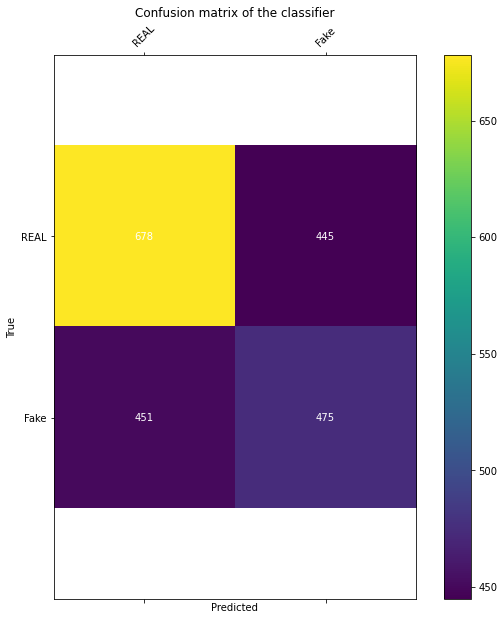

In [14]:
confusion_matrix_heatmap(y, pred, labels=['REAL','Fake'])
#display confusion matrix for visualisation on false negative false positives true negatives and true positives

In [15]:
# document creator to take the false negatives and false positives and document this which can be used for analysis

f_size = int((len(test_data)/10)+1)
test = test_data[0:0+f_size]
x_error = [i[0] for i in test]
y_error = [i[1] for i in test]
error = predict_labels(x_error,cross_val)

for i in range(len(error)):
    #iterate through errors check if false positive or negative and seperate out 
    if pred[i] == 'REAL':
        if y_error[i]== 'FAKE':
            with open('false_pos.txt','a') as f:
                print('\n false positive => predicted: REAL => ground truth: FAKE\n', x_error[i], file=f)
                
        else:
            if y_error[i] == 'REAL':
                with open('false_neg.txt','a') as f:
                    print('\n false negative => predicted: FAKE => ground truth: Real\n', x_error[i], file=f)

# Questions 5 (20%) and 6 (20%) (recommend starting a new notebook)

In [16]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'the': 2, 'bush': 1, 'tax': 1, 'cuts': 1, 'helped': 1, 'to': 1, 'create': 1, 'a': 1, 'substantial': 1, 'part': 1, 'of': 1, 'deficit': 1, '.': 1}, 'REAL')
Training Classifier...
Done training!
Precision: 0.562467
Recall: 0.562714
F Score:0.562585
